In [14]:
#defining file path for test dataset
dataset = "IN-Abs" # Options: IN - IN-Abs, UK-UK-Abs, N2-IN-Ext
output_path = "/kaggle/working/output/"

In [15]:
cd /kaggle/input/utilis

/kaggle/input/utilis


In [16]:
#importing necessary libraries
import pandas as pd
import numpy as np
import glob
import sys
sys.path.insert(0, '../')
from utilities import *
import os
import nltk

In [17]:
#creating output directory if it doesnt exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [18]:
names, data_source, data_summary = get_summary_data(dataset, "test")

In [19]:
cd /kaggle/input/

/kaggle/input


In [20]:
#references is a list containg all the summaries in the test dataset
references=list()
for reference_summary in data_summary[:1]:
    references.append(reference_summary)

In [21]:
summarylength=list()
docid=list()
for i in references:
    summarylength.append(len(i.split(" ")))
for i in range(1,len(summarylength)+1):
    docid.append(i)

In [22]:
# print(summarylength)
# print(docid)

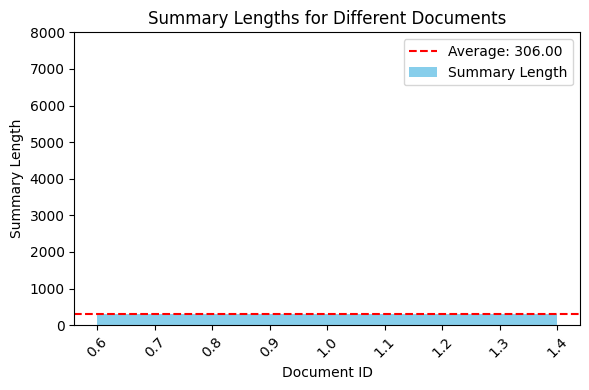

In [23]:
import matplotlib.pyplot as plt

avg_summary_length = np.mean(summarylength)

# Plotting
plt.figure(figsize=(6, 4))  # Adjust figure size if needed
plt.bar(docid, summarylength, color='skyblue', label='Summary Length')
plt.axhline(y=avg_summary_length, color='red', linestyle='--', label=f'Average: {avg_summary_length:.2f}')
plt.xlabel('Document ID')
plt.ylabel('Summary Length')
plt.ylim(0, 8000)
plt.title('Summary Lengths for Different Documents')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

In [24]:
total_length = sum(len(string.split(" ")) for string in references)
l=len(references[0].split(" "))
for i in references:
    l=max(l,len(i.split(" ")))
print(l)
print(references[0])
# Calculate average length
average_length = total_length / len(references)
print(average_length)

306
The appellants who are displaced persons from West Pakistan, were granted quasi permanent allotment of some lands in village Raikot in 1949.
On October 31, 1952, the Assistant Custodian cancelled the allotment of 14 allottees in village Karodian, and also cancelled the allotment of the Appellants in Raikot but allotted lands to them in village Karodian, and allotted the lands of Raikot to other persons.
The 14 allottees of village Karodian as well as the appellants applied for review of the orders of cancellation of their allotment.
The application of the 14 allottees was dismissed.
They preferred a revision to the Custodian General who cancelled the appellant 's allotment (1) Cal.
926. 329 in Karodian and restored the allotment of the 14 allottees on December 17, 1954 Thereupon,, on January 6, 1955, the appellants moved the Custodian General for calling up their review application and for revising the order of October 31, 1952, cancelling their allotment in Raikot.
The Custodian G

In [25]:
cd /kaggle/input/bart-utilities

/kaggle/input/bart-utilities


In [26]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, BartForConditionalGeneration, BartTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, BartConfig
from BART_utilities import *
#loading gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned pegasus model
pegasus_tokenizer = AutoTokenizer.from_pretrained("nsi319/legal-pegasus") 
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/input/output-model")
pegasus_model.to(device)


# Loading Bart Model and tokenizer



base_bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
base_bart_model.to(device)

bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', add_prefix_space=True)
new_tokens = ['<F>', '<RLC>', '<A>', '<S>', '<P>', '<R>', '<RPC>']
special_tokens_dict = {'additional_special_tokens': new_tokens}
num_added_toks = bart_tokenizer.add_special_tokens(special_tokens_dict)
base_bart_model.resize_token_embeddings(len(bart_tokenizer))
print(len(bart_tokenizer))

# Load the fine-tuned bart model
bart_model = LitModel(learning_rate = 2e-5, tokenizer = bart_tokenizer, model = base_bart_model)
bart_model.load_state_dict(torch.load("/kaggle/input/bartmodel/outputBARTModel (1).pt"))
bart_model.to(device)

50272


LitModel(
  (model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50272, 1024)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50272, 1024)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0-11): 12 x BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
           

In [27]:
from difflib import SequenceMatcher

def similarity_score(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

In [29]:
!pip install -U sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3253c2e6412b114dcbeda426b56ee72432560f32eb72bee90b416e3dc0b44c25
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [30]:
from sentence_transformers import SentenceTransformer
sentenceEncodermodel = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

In [49]:

from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_score(text1, text2):
    sentence_embeddings = sentenceEncodermodel.encode([text1,text2])
    similarity_scores = cosine_similarity([sentence_embeddings[0]],[sentence_embeddings[1]])
    return similarity_scores[0][0]

In [33]:
def ensemble_summarizer(text):
# Generate summary using Legal PEGASUS
    pegasus_input_tokenized = pegasus_tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
    pegasus_input_tokenized = pegasus_input_tokenized.to(device)  # Move input tensor to GPU if available
    # Ensure the model and input tensors are on the same device
    with torch.no_grad():
        pegasus_summary_ids = pegasus_model.generate(pegasus_input_tokenized,
                                                num_beams=9,
                                                no_repeat_ngram_size=3,
                                                length_penalty=2.0,
                                                min_length=200,
                                                max_length=1000,
                                                early_stopping=True)
    pegasus_summary = [pegasus_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in pegasus_summary_ids][0]
   

    
    # Generate summary using BART
    
    bart_input_tokenized = bart_tokenizer.encode(text, truncation=True, return_tensors='pt')
    bart_input_tokenized = bart_input_tokenized.to(device)
    bart_summary_ids = bart_model.model.to(device).generate(bart_input_tokenized,
                                  length_penalty=0.01,
                                  min_length=200,
                                  max_length=1000)
    bart_summary = [bart_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in bart_summary_ids][0]

  
    
    
    bart_legal_similarity = cosine_similarity_score(bart_summary, pegasus_summary)
#     print("score"+str(bart_legal_similarity))
    # Select the summary with higher similarity or a specific threshold
    if bart_legal_similarity >=0.8:  # Adjust the threshold as needed
        ensemble_summary = bart_summary  # Select BERT summary
    else:
        # If the similarity is low, choose the longer summary as the ensemble result
        if len(bart_summary) >= len(pegasus_summary):
            ensemble_summary = bart_summary
        else:
            ensemble_summary =pegasus_summary
    
    return ensemble_summary
    
    
#     # Voting mechanism: Choose the summary with the highest score (simple voting)
#     # Here, we are using a simple approach where we count the number of words in the summaries
#     pegasus_words = len(pegasus_summary.split())
#     bart_words = len(bart_summary.split())

#     # Choose the summary with the higher word count
#     final_summary = pegasus_summary if pegasus_words > bart_words else bart_summary

#     return final_summary


Evaluating the model

In [35]:
!pip install evaluate
!pip install rouge_score

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=5a5d0c9512745818a679111639899a437752f260e8d71536e2d7bd8ada483e9e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [50]:
from evaluate import load
# Load the ROUGE metric
import evaluate

candidates=list()
for text in data_source[:1]:
    candidates.append(ensemble_summarizer(text))

# rouge = evaluate.load('rouge')

# results = rouge.compute(predictions=candidates, references=references)

# print(results)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2
0.8802454


In [ ]:
# # a new function that takes in the list of rhetorical roles and the judgements, removes each rhetorical role one by one and generates the summary using ensemble summarizer. and stores that summary.
# # so we will need 13 lists each list consisting of the summaries of all the judgements formed after removing that one rhetorical role.
# rogueResults=dict()

# def removeRhetoricalRole(role,data_source):
#     #A function that takes in the rhetorical role and the text and removes the rhetorical role of the text and returns the new text
#     removed_role_data_source=list()

#     for text in data_source:
#         #for loop passing through each text in  datasource and removing the rr and append that to a list removed_role_data_source.
#         updated_text=text #code to remove rr
#         removed_role_data_source.append(updated_text)
# cha
#     return removed_role_data_source


# roles = ['PREAMBLE','NONE','FAC','ISSUE','ARG_PETITIONER','RLC','ANALYSIS','PRE_RELIED','RATIO','RPC','STA','ARG_RESPONDENT','PRE_NOT_RELIED']

# def rhetoricalRole_Analysis(roles, data_source):

#     for role in roles:
#         removed_rr_summaries=list()
#         removed_RR_data_source= removeRhetoricalRole(role,data_source)

#         for text in removed_RR_data_source[:1]:
#             removed_rr_summaries.append(ensemble_summarizer(text))
            
#         rouge = evaluate.load('rouge')

#         results_references = rouge.compute(predictions=removed_rr_summaries, references=references[:1])
#         results_generated = rouge.compute(predictions=removed_rr_summaries, references=candidates[:1])
        
#         rogueResults[role]=dict()
#         rogueResults[role]["Reference"]=results_references
#         rogueResults[role]["Generated"]=results_generated

        
    
    


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction



# Calculate BLEU scores
bleu = corpus_bleu(references, candidates)

print(f'Ensemble BLEU Score: {bleu:.4f}')


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
bleu2Results = corpus_bleu(references, candidates, weights=(0.5, 0.5), smoothing_function=SmoothingFunction().method4)
print(bleu2Results)